# Reto: Modelo basado en *deep learning* para la discriminación entre gatos y perros

**Objetivos**:
- Diseñar modelos de redes neuronales profundas (*deep learning*), enfocándose en la clasificación de imágenes de acuerdo a categrías preestablecidas para resolver problemas con relevancia social, permitiendo valor en los diversos sectores.
- Crear modelos de datos *Deep Neural Networks* (DNN) utilizando PyTorch basado en Python; seleccionando el modelo adecuado y analizando la exactitud del modelo, para cumplir lo mejor posible con los requerimientos de la tarea requerida.

## 1. Preprocesamiento de la base de datos

Montando Google Drive y cargando librerías necesarias

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Importando bibliotecas
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split
from torchsummary import summary
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import numpy as np
import pathlib

La siguiente línea de código elimina las fotos que sean JPG, JPEG o PNG.

In [ ]:
# Eliminando cualquier archivo que no sea JPG, JPEG, PNG
!find /content/drive/MyDrive/Reto_PyTorch/catsvsdogs -type f ! -name '*.jpg' ! -name '*.jpeg' ! -name '.*png' -delete

A continuación, se establece el directorio base y se cuenta el total de imágenes.

In [ ]:
# Directorio base
data_dir = pathlib.Path('/content/drive/MyDrive/Reto_PyTorch/catsvsdogs')
conteo_img = len(list(data_dir.glob('*/*')))
print('Total de imágenes a analizar:', conteo_img)

Total de imágenes a analizar: 4895


Para procesar las imágenes, es ideal que las fotos estén en un tamaño de 224x224 pixeles, y después, transformarlas a un tensor.

In [ ]:
# Transformaciones
transform = transforms.Compose([
    # Ajustar tamaño de la imagen
    transforms.Resize((224,224)),
    # Transformar a tensor
    transforms.ToTensor(),
])

### 1.2 Normalización de las imágenes

A continuación se crea un dataset a partir de la carpeta con ```ImageFolder``` sin normalizar. Se usará inicialmente la transformación anteriormente definida para crear un DataLoader para iterar sobre los datos en batches.

Posteriormente, se calcula el promedio y desviación estándar para normalizar las imágenes de manera correcta. Esto se hace con el objetivo de mejorar el entrenamiento


In [ ]:
# Imagenes sin normalizar
dataset = datasets.ImageFolder(data_dir, transform=transform)
loader = DataLoader(dataset,batch_size=64,shuffle=False,num_workers=2)

# Calculando promedio y desviación estándar
mean = 0
std = 0
total_imgs = 0
for images,_ in loader:
    batch_samples = images.size(0)
    images = images.view(batch_samples,images.size(1),-1) # (batch,canales,pixeles)
    mean += images.mean(2).sum(0)
    std += images.std(2).sum(0)
    total_imgs += batch_samples
mean = mean/total_imgs
std = std/total_imgs
print('Promedio:', mean)
print('Desviación estándar:', std)

Promedio: tensor([0.4815, 0.4475, 0.3969])
Desviación estándar: tensor([0.2255, 0.2230, 0.2250])


Para la transformación se hará lo siguiente:
1. Resize: cambiar tamaño de la imagen a 224x224 pixeles.
2. Convertir la imagen a tensor con valores entre 0 y 1.
3. Nora,jzar cada canal RGB usando el promedio y desviación estándar para que los valores queden centrados y escalados.

In [ ]:
# Transformación final
transform = transforms.Compose([
    # Ajustar tamaño de la imagen
    transforms.Resize((224,224)),
    # Transformar a tensor
    transforms.ToTensor(),
    # Normalizar
    transforms.Normalize(mean = [0.4815,0.4475,0.3969],
                        std = [0.2255,0.2230,0.2250])
])

## 2. Sets de Entrenamiento y Validación



En este paso, se van a definir los sets de entrenamiento y validación, **80% será para entrenamiento** y **20% será para validación**.
Así mismo, se crean los ```DataLoaders``` para iterar sobre los batches.


In [ ]:
# Dataset completo desde el directorio establecido
dataset = datasets.ImageFolder(data_dir, transform=transform)

# División: 80% entrenamiento, 20% validación
train_size = int(0.8*len(dataset))
val_size = len(dataset) - train_size

train_set, val_set = random_split(dataset, [train_size, val_size])

# Batch
batch_size = 32
train_loader = DataLoader(train_set,batch_size=batch_size,shuffle=True)
val_loader = DataLoader(val_set,batch_size=batch_size,shuffle=False)

# Tamaño de los sets
print(f'Imágenes:',len(dataset))
print(f'Entrenamiento', len(train_set))
print(f'Validación', len(val_set))

Imágenes: 4895
Entrenamiento 3916
Validación 979


## 3. Construcción de la Red Neuronal

A continuación se define una red neuronal totalmente conectada (MLP) para una **clasificación binaria**.

In [ ]:
class MultiLayerPerceptron(nn.Module):
    def __init__(self,input_size = 224*224*3,output_size = 2):
        super().__init__()
        self.fc1 = nn.Linear(input_size,512)
        self.fc2 = nn.Linear(512,128)
        self.fc3 = nn.Linear(128,64)
        self.fc4 = nn.Linear(64,output_size)

    def forward(self,X):
        X = X.view(X.shape[0],-1)
        X = F.relu(self.fc1(X))
        X = F.relu(self.fc2(X))
        X = F.relu(self.fc3(X))
        X = self.fc4(X)
        return X

 # Creando el modelo
model = MultiLayerPerceptron()

# Ver la estructura del modelo
print(model)

MultiLayerPerceptron(
  (fc1): Linear(in_features=150528, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=64, bias=True)
  (fc4): Linear(in_features=64, out_features=2, bias=True)
)


Así mismo, se tiene que definir la función de pérdida y el optimizador Adam.

In [ ]:
# Definiendo pérdida y optimizador
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(),lr=0.001)

# Mover a GPU si está disponible
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

## 4. Definición de Funciones Para Entrenamiento y Validación

### 4.1 Función de Entrenamiento

Se define la función de entrenamiento, se define el forward pass, así como el backward pass y la actualización de pesos.

In [ ]:
# Función para entrenar
def train(model,train_loader,criterion,optimizer,device):
    # Modelo en modo entrenamiento
    model.train()

    # Mover medole a dispositivo especificado (GPU/CPU)
    model.to(device)

    # Valores para seguir el historial de pérdida y precisión
    running_loss = 0
    correct_predictions = 0
    total_samples = 0

    # Ciclo sobre el set de entrenamiento
    for images,labels in train_loader:
        # Mover a GPU/CPU
        images,labels = images.to(device), labels.to(device)

        # Reiniciar gradiente para prevenir acumulación
        optimizer.zero_grad()

        # Forward pass, obtener predicción
        outputs = model(images)

        # Calcular pérdida
        loss = criterion(outputs,labels)

        # Backward pass
        loss.backward()

        # Actualizar los parametros del modelo
        optimizer.step()

        # Acumulado de la pérdida
        running_loss += loss.item()

        # Obtener probabilidad maximo de la clase predicha
        _, predicted = torch.max(outputs.data,dim = 1)

        # Acumulado de predicciones correctas
        correct_predictions += (predicted == labels).sum().item()

        # Acumulado de muestras
        total_samples += labels.size(0)

    # Promedio de perdida
    avg_loss = running_loss / len(train_loader)

    # Precisión
    accuracy = correct_predictions / total_samples

    # Precisión (%)
    accuracy = 100 * correct_predictions / total_samples

    return avg_loss, accuracy


### 4.2 Validación de la Red *Neuronal*

A continuaciónn se define la función de validación, sin gradientes.

In [ ]:
def validate(model,val_loader,criterion,device):
    # Modelo en modo evaluación
    model.eval()

    # Mover medole a dispositivo especificado (GPU/CPU)
    model.to(device)

    running_loss = 0
    correct_predictions = 0
    total_samples = 0

    # No calcular gradientes
    with torch.no_grad():
        for images,labels in val_loader:
            # Mover a GPU/CPU
            images,labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs,labels)

            running_loss += loss.item()
            _, predicted = torch.max(outputs.data,dim = 1)
            correct_predictions += (predicted == labels).sum().item()
            total_samples += labels.size(0)

    avg_loss = running_loss / len(val_loader)
    accuracy = 100*correct_predictions / total_samples

    return avg_loss, accuracy


## 5. Entrenamiento y Validación de la Red Neuronal

### 5.1 Entrenamiento

En el entrenamiento se usarán 20 epochs, se guardarán las métricas en las listas para entrenamiento y validación, cada una tendrá una lista para precisión y pérdida. Esto tiene la finalidad de ver el rendimiento del entrenamiento.

In [ ]:
# Epochs
num_epochs = 20
train_losses, val_losses = [],[]
train_accuracy, val_accuracy = [],[]

# Entrenamiento
for epoch in range(num_epochs):
    train_loss, train_acc = train(model,train_loader,criterion,optimizer,device)
    val_loss, val_acc = validate(model,val_loader,criterion,device)

    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accuracy.append(train_acc)
    val_accuracy.append(val_acc)

    print(f'Epoch {epoch +1}/{num_epochs}')
    print(f' Train loss: {train_loss:.4f} | Train accuracy: {train_acc:.2f}%')
    print(f' Val loss: {val_loss:.4f} | Val accuracy: {val_acc:.2f}%')


Epoch 1/20
 Train loss: 1.2169 | Train accuracy: 54.80%
 Val loss: 0.8228 | Val accuracy: 54.55%
Epoch 2/20
 Train loss: 0.6979 | Train accuracy: 62.00%
 Val loss: 0.7704 | Val accuracy: 57.41%
Epoch 3/20
 Train loss: 0.6352 | Train accuracy: 66.62%
 Val loss: 0.8254 | Val accuracy: 56.28%
Epoch 4/20
 Train loss: 0.6055 | Train accuracy: 69.31%
 Val loss: 0.8337 | Val accuracy: 57.30%
Epoch 5/20
 Train loss: 0.5693 | Train accuracy: 71.99%
 Val loss: 0.7196 | Val accuracy: 58.73%
Epoch 6/20
 Train loss: 0.5317 | Train accuracy: 73.60%
 Val loss: 0.7525 | Val accuracy: 58.32%
Epoch 7/20
 Train loss: 0.4912 | Train accuracy: 76.61%
 Val loss: 0.8140 | Val accuracy: 61.70%
Epoch 8/20
 Train loss: 0.4498 | Train accuracy: 78.86%
 Val loss: 0.8115 | Val accuracy: 60.57%
Epoch 9/20
 Train loss: 0.4143 | Train accuracy: 82.18%
 Val loss: 0.8323 | Val accuracy: 62.10%
Epoch 10/20
 Train loss: 0.4091 | Train accuracy: 82.38%
 Val loss: 0.9521 | Val accuracy: 58.43%
Epoch 11/20
 Train loss: 0.32

### 5.2 Rendimiento de la Red Neuronal

Se grafican las curvas de pérdida y precisión del MLP.

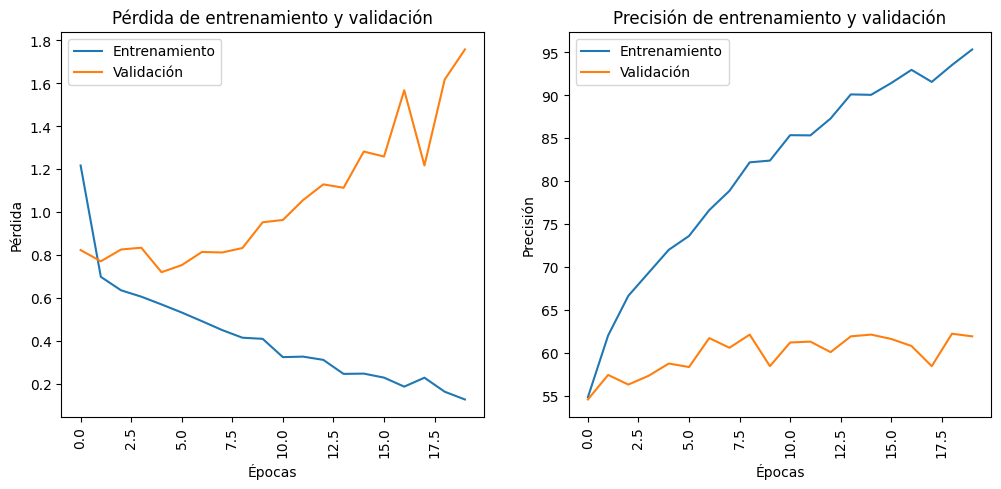

In [ ]:
plt.figure(figsize=(12,5))

# Pérdida
plt.subplot(1,2,1)
plt.plot(train_losses,label='Entrenamiento')
plt.plot(val_losses,label='Validación')
plt.xlabel('Épocas')
plt.ylabel('Pérdida')
plt.xticks(rotation=90)
plt.title('Pérdida de entrenamiento y validación')
plt.legend()

# Precisión
plt.subplot(1,2,2)
plt.plot(train_accuracy,label='Entrenamiento')
plt.plot(val_accuracy,label='Validación')
plt.xlabel('Épocas')
plt.ylabel('Precisión')
plt.xticks(rotation=90)
plt.title('Precisión de entrenamiento y validación')
plt.legend()

plt.show()

Como se puede observar, el modelo anterior predice muy bien el set de entrenamiento, mientras que con el set de validación aprende lentamente. Por lo cual, se puede concluir que con una red neuronal sin operaciones de convolución es difícil obtener resultados óptimos.

## 6. Red Neuronal Convolucional

### 6.1 Transformaciones

Para tener una buena CNN, es necesario definir unas nuevas transformaciones con data augmentation. En este caso, las imágenes serán de tamaño 64x64 pixeles.

In [ ]:
# Transformación final
transform = transforms.Compose([
    # Ajustar tamaño de la imagen
    transforms.Resize((64,64)),
    # Transformar a tensor
    transforms.ToTensor(),
    # Normalizar para que los valores se encuentren entre 0 y 1
    transforms.Normalize(mean = [0.5,0.5,0.5],
                        std = [0.5,0.5,0.5]),
    # Data Augmentation
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10)
])


### 6.2 Sets de Entrenamiento y Validación

Nuevamente, se carga y divide los datasets para entrenamiento.

In [ ]:
# Dataset completo desde el directorio establecido
dataset = datasets.ImageFolder(data_dir, transform=transform)

# División: 80% entrenamiento, 20% validación
train_size = int(0.8*len(dataset))
val_size = len(dataset) - train_size

train_set, val_set = random_split(dataset, [train_size, val_size])

# Batch
batch_size = 32
train_loader = DataLoader(train_set,batch_size=batch_size,shuffle=True)
val_loader = DataLoader(val_set,batch_size=batch_size,shuffle=False)

# Tamaño de los sets
print(f'Imágenes:',len(dataset))
print(f'Entrenamiento', len(train_set))
print(f'Validación', len(val_set))

Imágenes: 4895
Entrenamiento 3916
Validación 979


### 6.3 Arquitectura de la Red Neuronal Optimizada

Se define la arquitectura de la red neuronal. Así mismo, se cera el modelo, el criterio, optimizador y scheduler para ajustar el learning rate.

In [ ]:
class ConvNet64(nn.Module):
    def __init__(self, num_classes=2):
        super().__init__()
        self.conv1 = nn.Conv2d(3,32,kernel_size=3,padding=1,stride=1)
        self.pool1 = nn.MaxPool2d(2,2)

        self.conv2 = nn.Conv2d(32,64,kernel_size=3,padding=1,stride=1)
        self.pool2 = nn.MaxPool2d(2,2)

        self.conv3 = nn.Conv2d(64,128,kernel_size=3,padding=1,stride=1)
        self.pool3 = nn.MaxPool2d(2,2)

        self.dropout = nn.Dropout(0.5)

        self.fc1 = nn.Linear(128*8*8,256)
        self.fc2 = nn.Linear(256,num_classes)

    def forward(self, X):
        X = self.pool1(F.relu(self.conv1(X)))
        X = self.pool2(F.relu(self.conv2(X)))
        X = self.pool3(F.relu(self.conv3(X)))
        X = X.view(X.size(0),-1)
        X = self.dropout(F.relu(self.fc1(X)))
        X = self.fc2(X)
        return X

# Creando modelo, criterio y optimizador
model_2 = ConvNet64()
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_2.parameters(),lr=0.0005)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Scheduler para reducir Learning Rate cada 7 epochs
scheduler = torch.optim.lr_scheduler.StepLR(optimizer,step_size=7,gamma=0.1)

# Estructura del modelo
print(model_2)

ConvNet64(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout): Dropout(p=0.5, inplace=False)
  (fc1): Linear(in_features=8192, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=2, bias=True)
)


## 7. Entrenamiento y Validación de la Red Neuronal Convolucionada

### 7.1 Entrenamiento

Entrenamiento y validación para la CNN, así mismo, se guardarán las métricas del rendimiento de la red.

In [ ]:
num_epochs = 25
train_losses2, val_losses2 = [],[]
train_accuracy2, val_accuracy2 = [],[]
# Entrenamiento
for epoch in range(num_epochs):
    train_loss2, train_acc2 = train(model_2,train_loader,criterion,optimizer,device)
    val_loss2, val_acc2 = validate(model_2,val_loader,criterion,device)

    train_losses2.append(train_loss2)
    val_losses2.append(val_loss2)
    train_accuracy2.append(train_acc2)
    val_accuracy2.append(val_acc2)

    print(f'Epoch {epoch +1}/{num_epochs}')
    print(f' Train loss: {train_loss2:.4f} | Train accuracy: {train_acc2:.2f}%')
    print(f' Val loss: {val_loss2:.4f} | Val accuracy: {val_acc2:.2f}%')

    scheduler.step()


Epoch 1/25
 Train loss: 0.6715 | Train accuracy: 57.48%
 Val loss: 0.6099 | Val accuracy: 66.60%
Epoch 2/25
 Train loss: 0.6095 | Train accuracy: 66.60%
 Val loss: 0.5683 | Val accuracy: 70.89%
Epoch 3/25
 Train loss: 0.5835 | Train accuracy: 69.25%
 Val loss: 0.5565 | Val accuracy: 72.83%
Epoch 4/25
 Train loss: 0.5621 | Train accuracy: 71.02%
 Val loss: 0.5741 | Val accuracy: 69.25%
Epoch 5/25
 Train loss: 0.5482 | Train accuracy: 72.83%
 Val loss: 0.5479 | Val accuracy: 71.60%
Epoch 6/25
 Train loss: 0.5177 | Train accuracy: 74.39%
 Val loss: 0.5160 | Val accuracy: 74.97%
Epoch 7/25
 Train loss: 0.4983 | Train accuracy: 75.89%
 Val loss: 0.4914 | Val accuracy: 75.59%
Epoch 8/25
 Train loss: 0.4526 | Train accuracy: 78.88%
 Val loss: 0.4865 | Val accuracy: 77.22%
Epoch 9/25
 Train loss: 0.4418 | Train accuracy: 79.93%
 Val loss: 0.4971 | Val accuracy: 74.57%
Epoch 10/25
 Train loss: 0.4357 | Train accuracy: 80.18%
 Val loss: 0.4845 | Val accuracy: 75.28%
Epoch 11/25
 Train loss: 0.42

Como se pudo ver en el **último epoch**, se obtuvo una **precisión en el entrenamiento** de 81.41%, mientra que la **precisión de validación es de 76.40%**.

### 7.2 Rendimiento de la Red Neuronal Convolucional

Graficando la pérdida y precisión de entrenamiento y validación de la CNN.

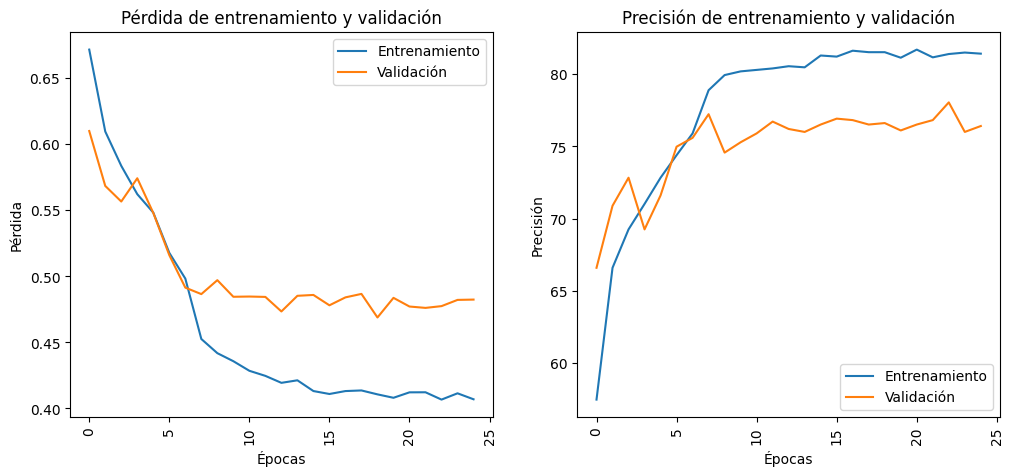

In [ ]:
plt.figure(figsize=(12,5))

# Pérdida
plt.subplot(1,2,1)
plt.plot(train_losses2,label='Entrenamiento')
plt.plot(val_losses2,label='Validación')
plt.xlabel('Épocas')
plt.ylabel('Pérdida')
plt.xticks(rotation=90)
plt.title('Pérdida de entrenamiento y validación')
plt.legend()

# Precisión
plt.subplot(1,2,2)
plt.plot(train_accuracy2,label='Entrenamiento')
plt.plot(val_accuracy2,label='Validación')
plt.xlabel('Épocas')
plt.ylabel('Precisión')
plt.xticks(rotation=90)
plt.title('Precisión de entrenamiento y validación')
plt.legend()

plt.show()

A continuación se mostrarán 5 imágenes del set de validación con sus probabilidades predichas.

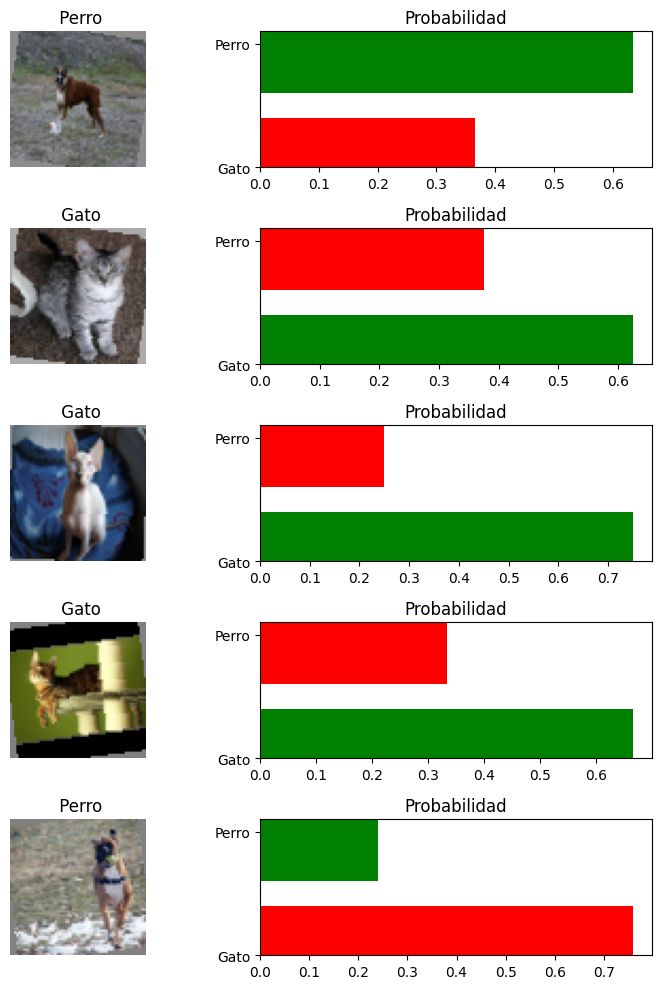

In [ ]:
# Obtener imagen de un conjunto de validación
dataiter = iter(val_loader)
images,labels = next(dataiter)

# Seleccionar las primeras 5 imágenes
num_images = 5
images_to_show = images[:num_images].to(device)
labels_to_show = labels[:num_images]

# Pasar imagen al modelo
model_2.eval()
with torch.no_grad():
    outputs = model_2(images_to_show)
    probabilities = torch.softmax(outputs,dim=1).cpu().numpy()

# Clases
classes = ['Gato','Perro']

# Graficar
fig, axes = plt.subplots(num_images,2,figsize=(8,2*num_images))

for i in range(num_images):
    img_np = images_to_show[i].permute(1,2,0).cpu().numpy()
    img_np = (img_np-img_np.min())/(img_np.max()-img_np.min())
    axes[i,0].imshow(img_np)
    axes[i,0].axis('off')
    axes[i,0].set_title(f' {classes[labels_to_show[i]]}')

    # Prediccion
    pred_class_idx = np.argmax(probabilities[i])
    pred_class = classes[pred_class_idx]

    # Colores: verde si acierta, rojo si falla
    colors = ['green' if j == labels_to_show[i] else 'red' for j in range(len(classes))]

    # Probabilidades
    axes[i,1].barh(classes,probabilities[i],color=colors)
    axes[i,1].set_ylim([0,1.1])
    axes[i,1].set_title(f'Probabilidad')

plt.tight_layout()
plt.show()

### 7.3 Guardar Modelo
Se guardará el modelo entrenado y las métricas en un archivo .pth.

In [ ]:
# Guardar modelo
torch.save({
    'epoch':25,
    'model_state_dict':model_2.state_dict(),
    'optimizer_state_dict':optimizer.state_dict(),
    'train_loss':train_losses2,
    'val_loss':val_losses2,
    'train_accuracy':train_accuracy2,
    'val_accuracy':val_accuracy2
},'/content/drive/MyDrive/Reto_PyTorch/cnn64.pth')